In [2]:

import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


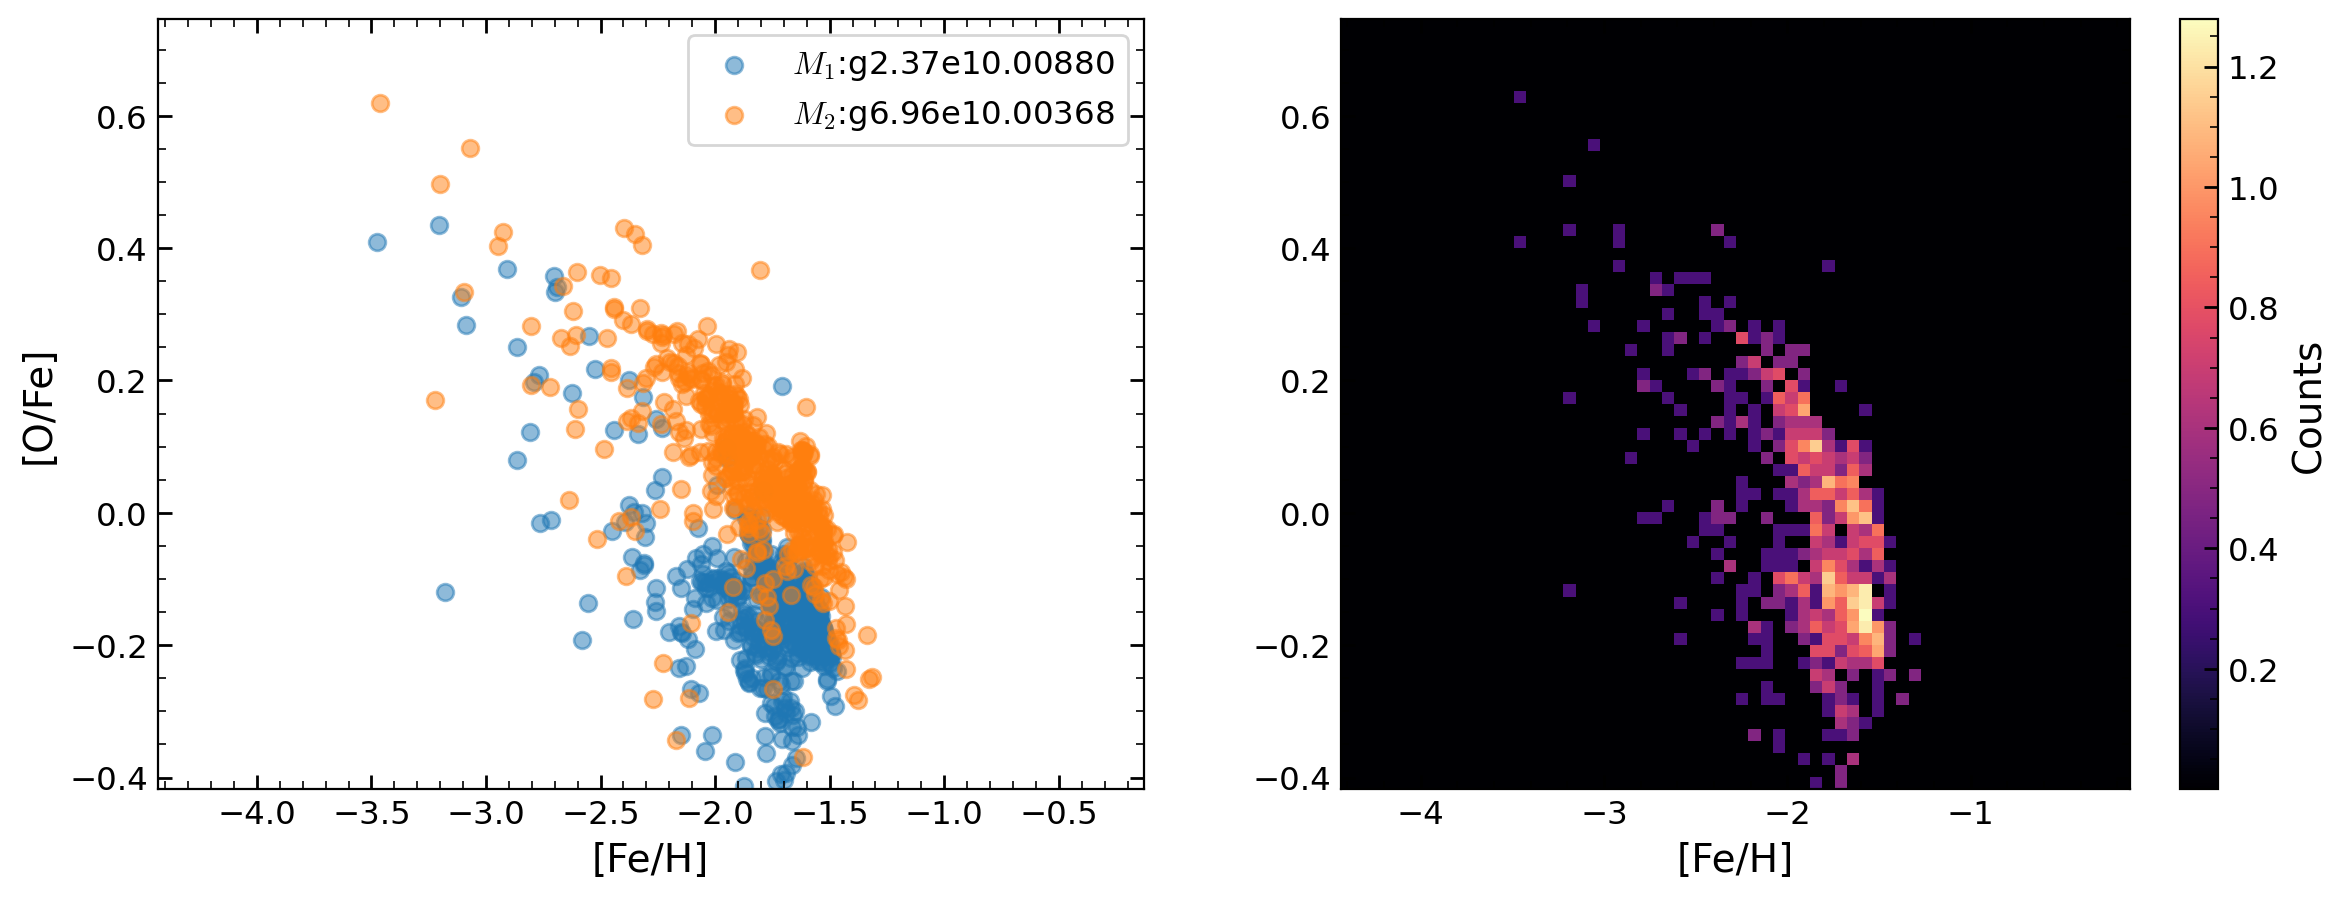

In [3]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',alpha=0.5)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
# ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

fig.savefig('scatter_2subhalos.png')

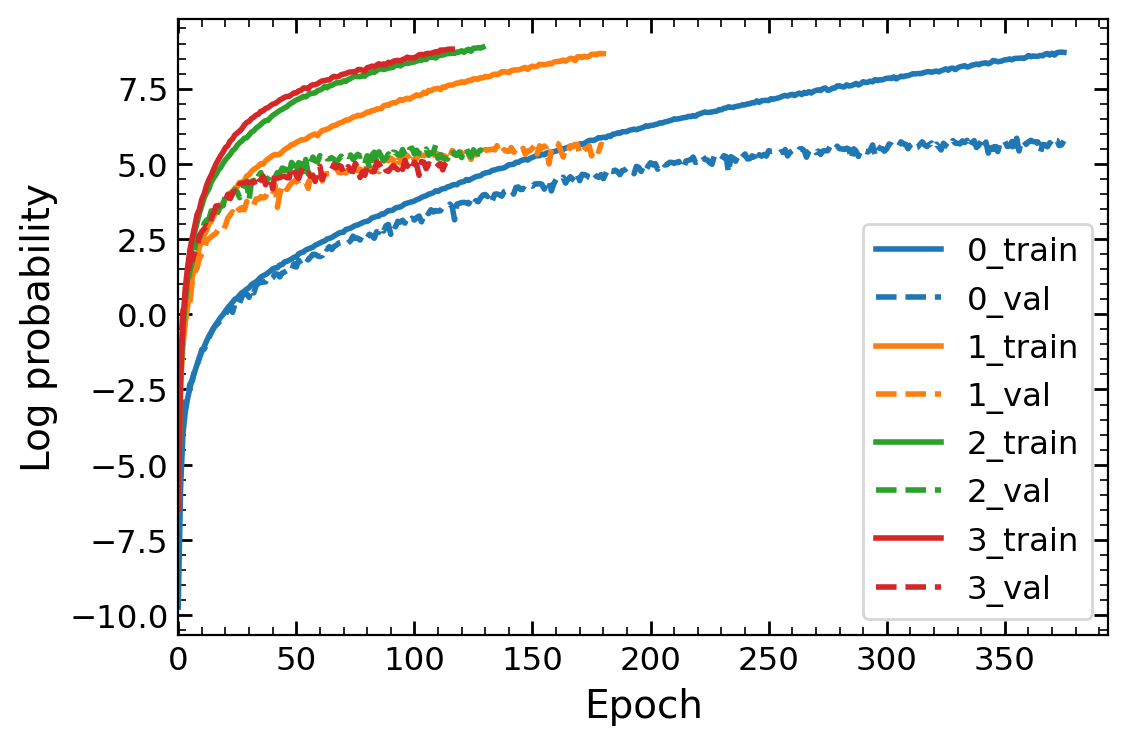

In [4]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [5]:
labels = [r'$\log_{10}(M_{s, 1})\ [M_\odot]$', r'$\log_{10}(M_{s, 2})\ [M_\odot]$', r'$\log_{10}(M_{DM, 1})\ [M_\odot]$', r'$\log_{10}(M_{DM, 2})\ [M_\odot]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$']

samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterior_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 1574 posterior samples:   0%|          | 0/1574 [00:00<?, ?it/s]

/export/home/vgiusepp/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 1374 posterior samples:   0%|          | 0/1374 [00:00<?, ?it/s]

Drawing 1315 posterior samples:   0%|          | 0/1315 [00:00<?, ?it/s]

Drawing 737 posterior samples:   0%|          | 0/737 [00:00<?, ?it/s]

Drawing 3119 posterior samples:   0%|          | 0/3119 [00:00<?, ?it/s]

Drawing 2672 posterior samples:   0%|          | 0/2672 [00:00<?, ?it/s]

Drawing 2606 posterior samples:   0%|          | 0/2606 [00:00<?, ?it/s]

Drawing 1603 posterior samples:   0%|          | 0/1603 [00:00<?, ?it/s]

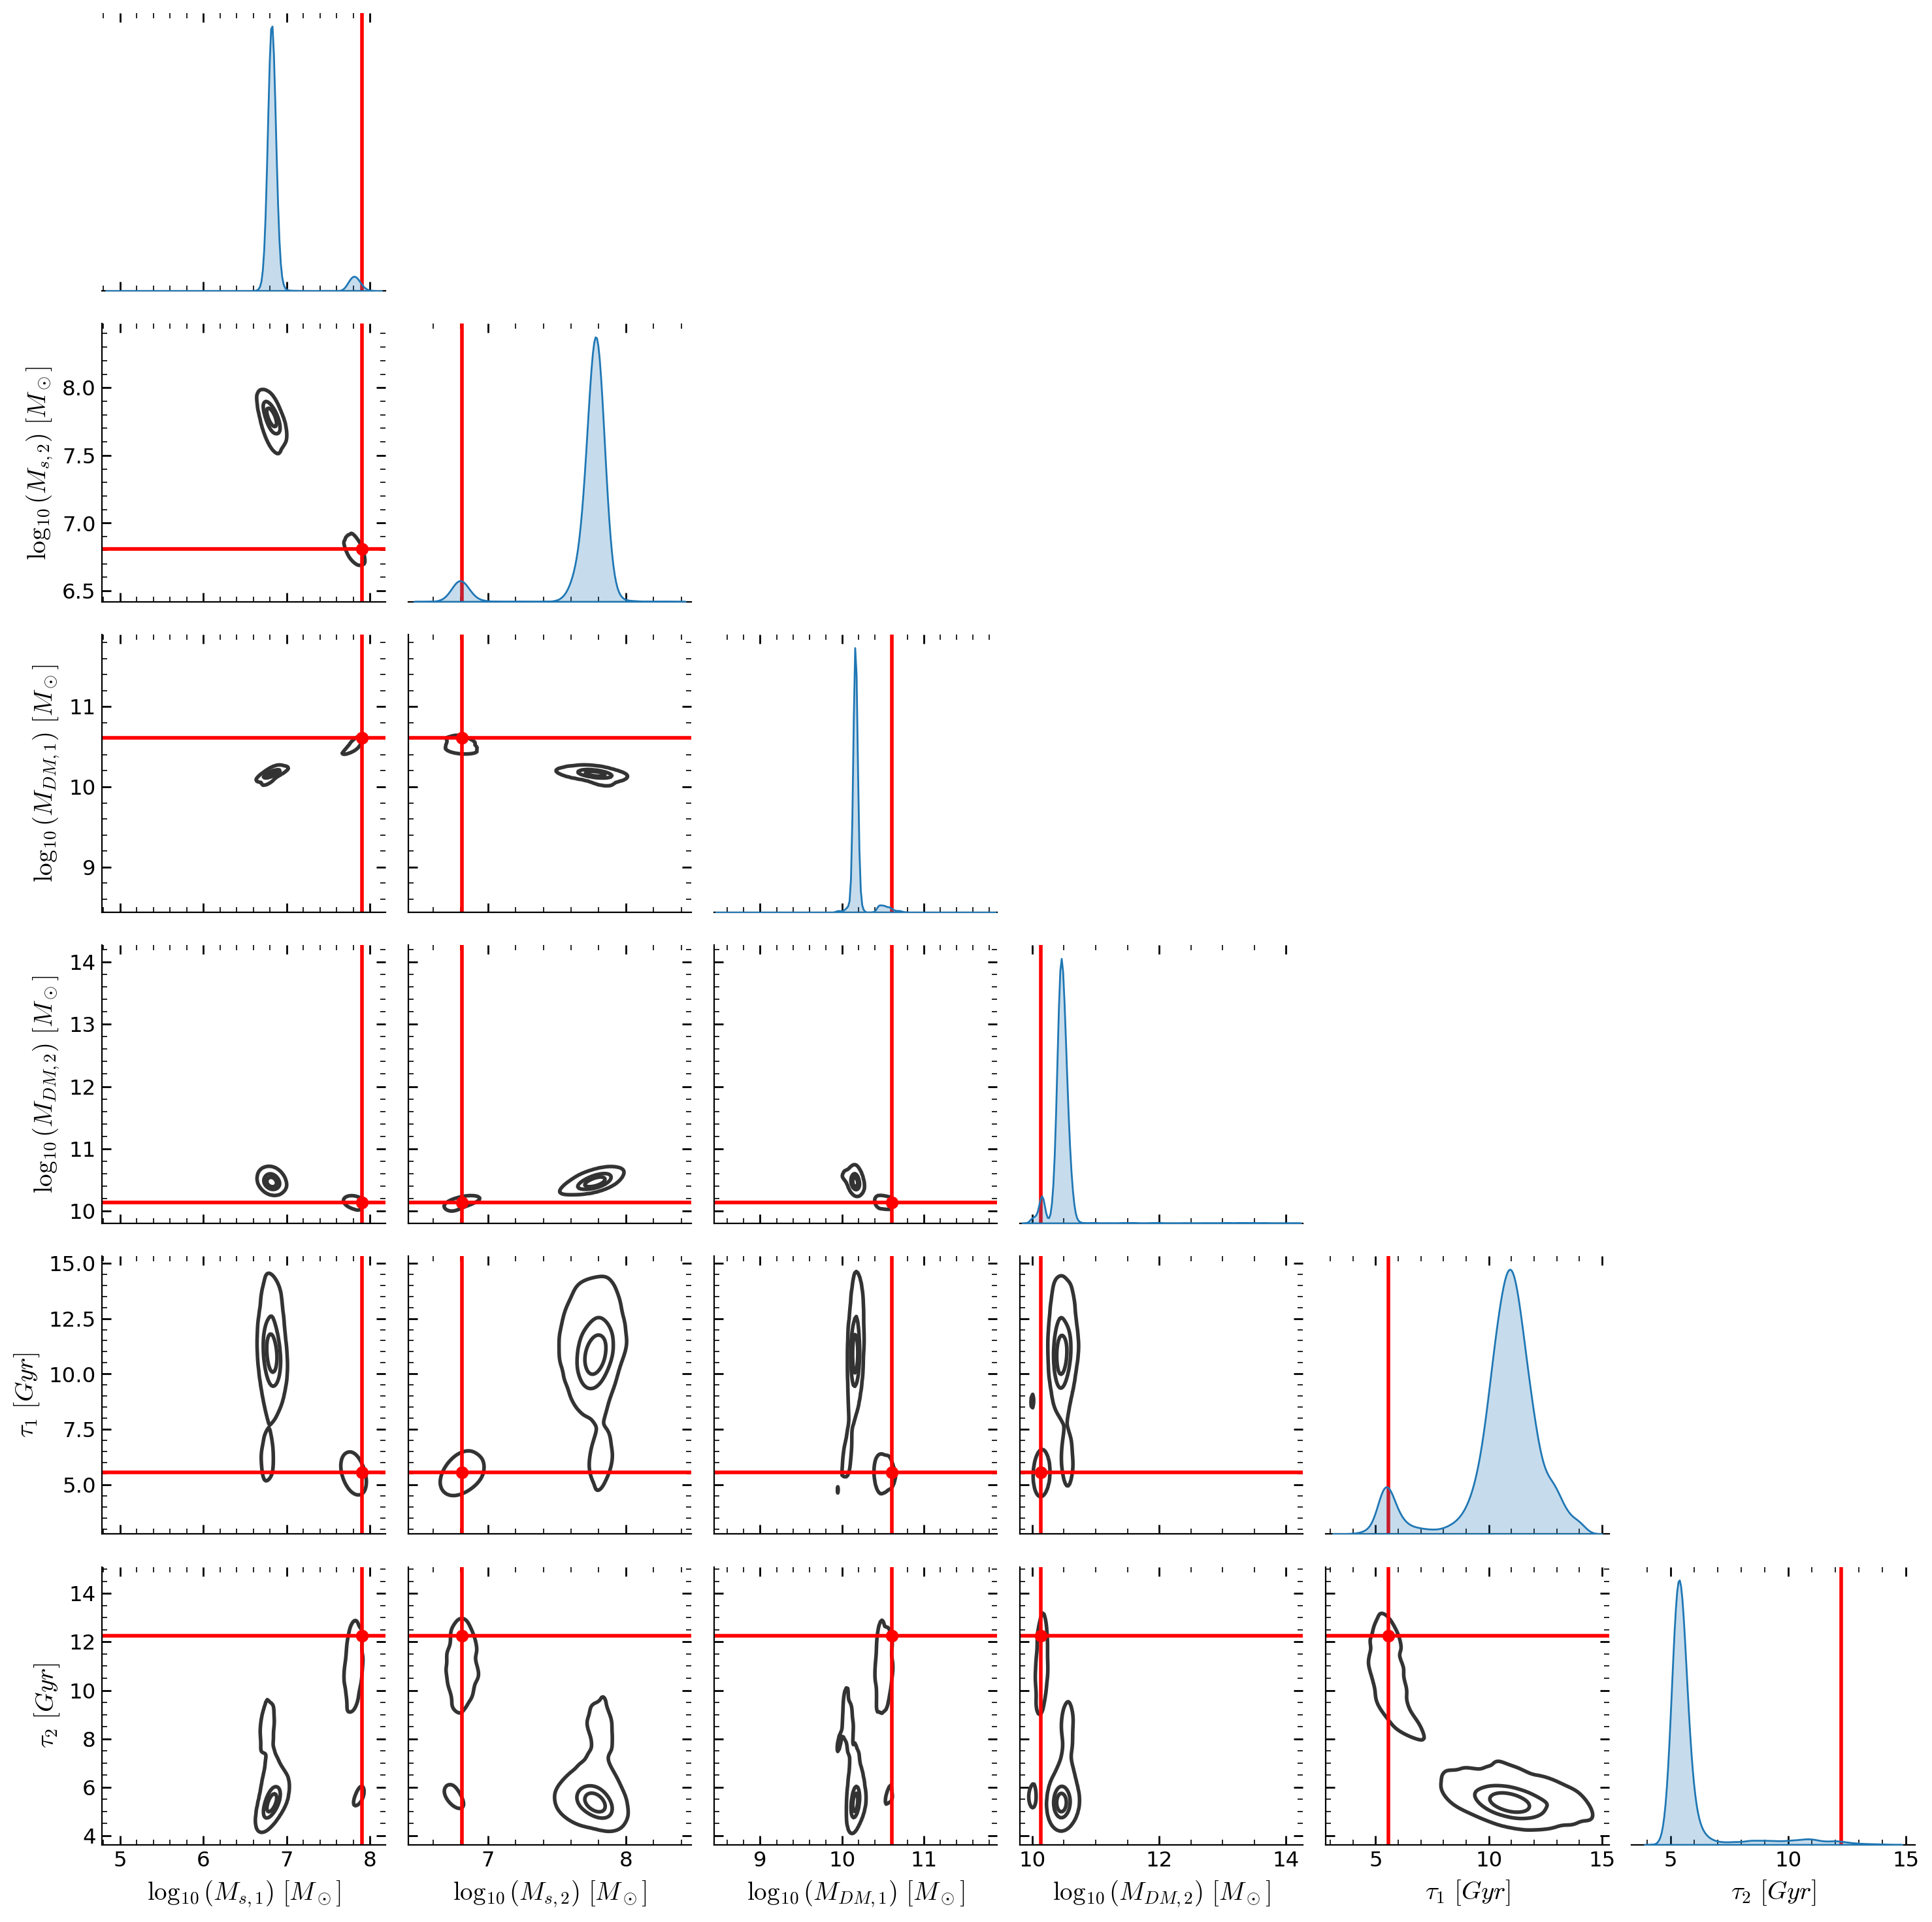

In [6]:
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)

fig.savefig('corner_2subhalos.png')

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: `bins` must be positive, when an integer

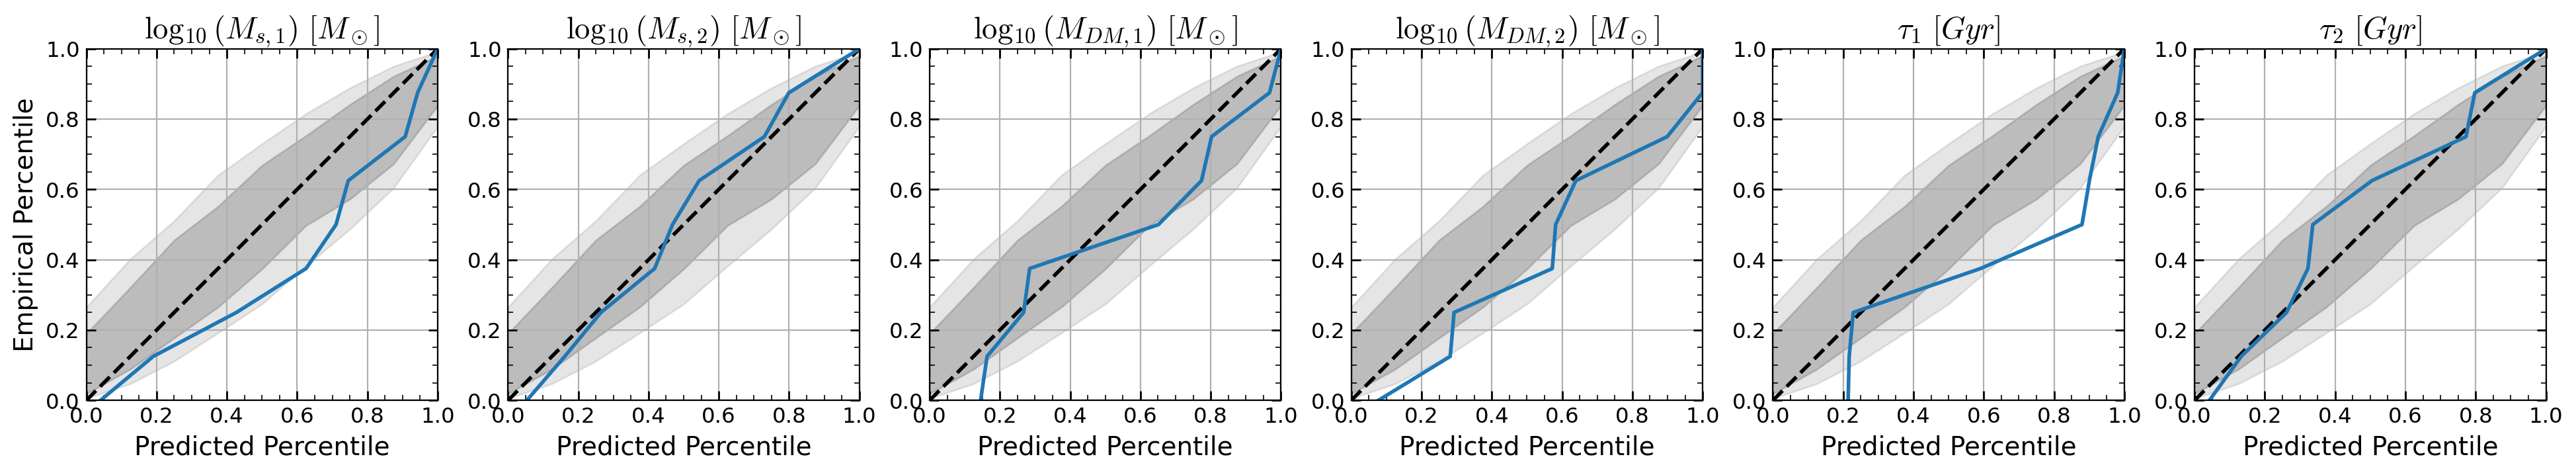

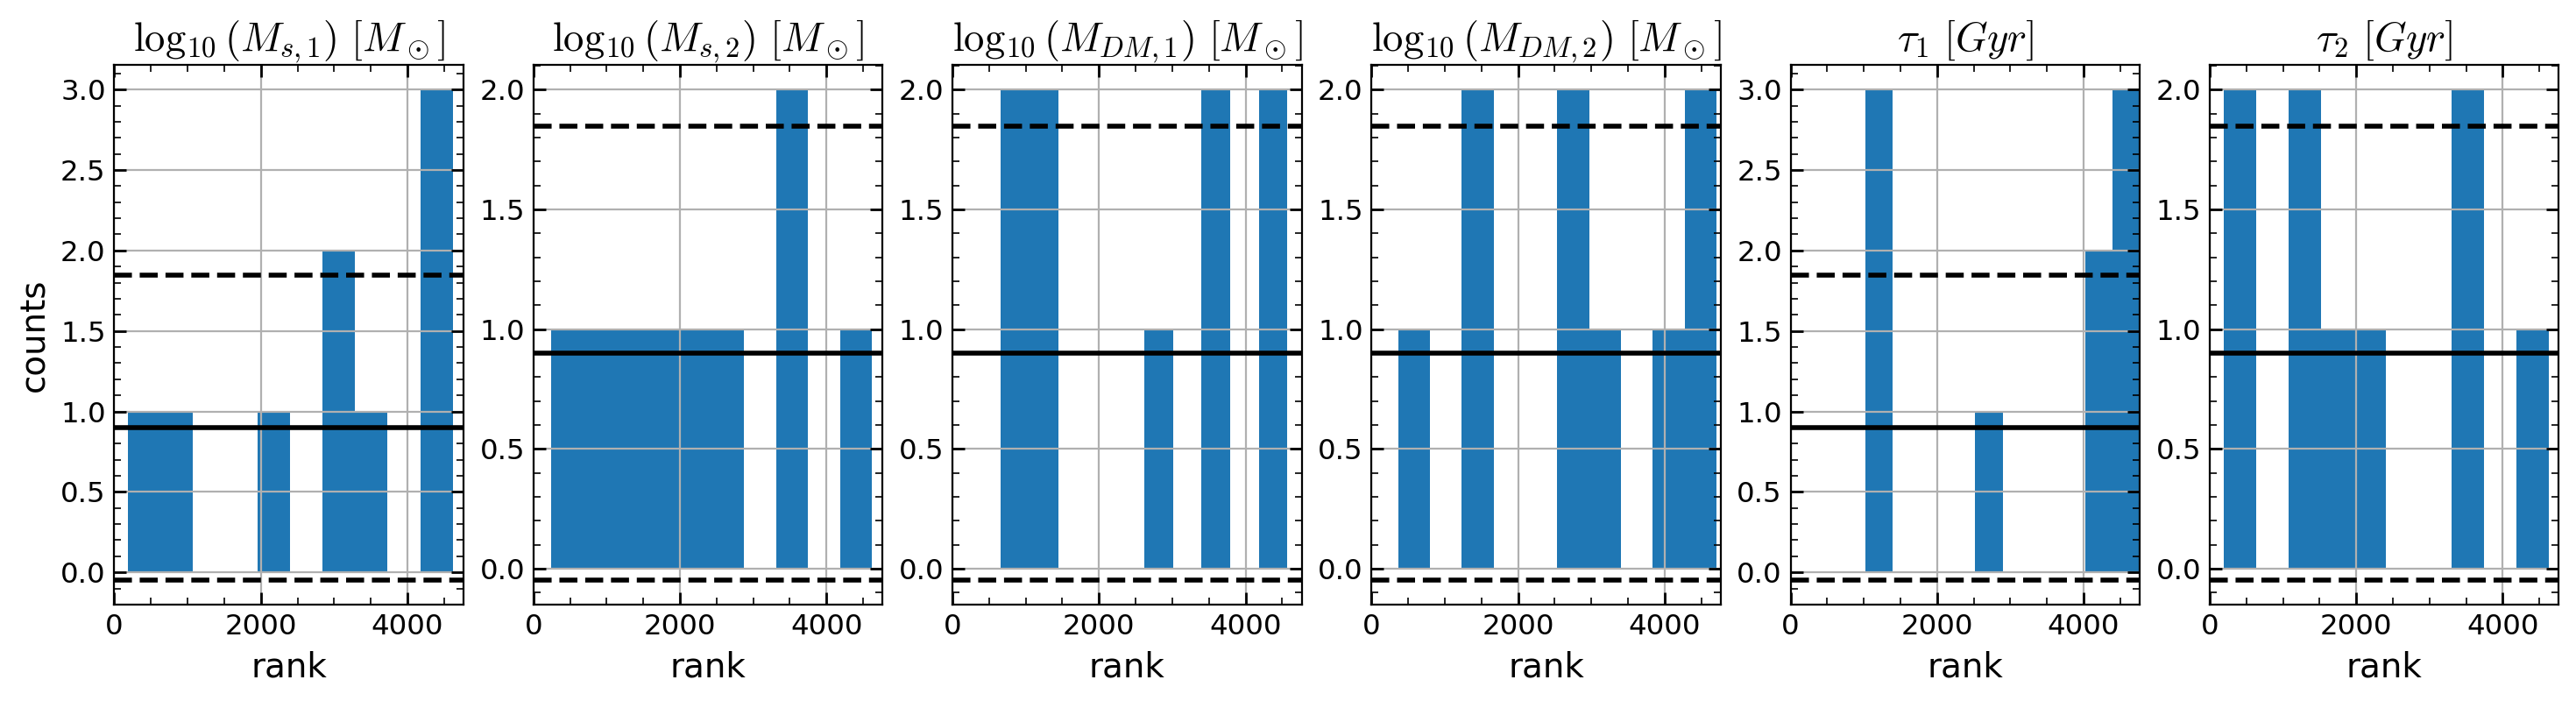

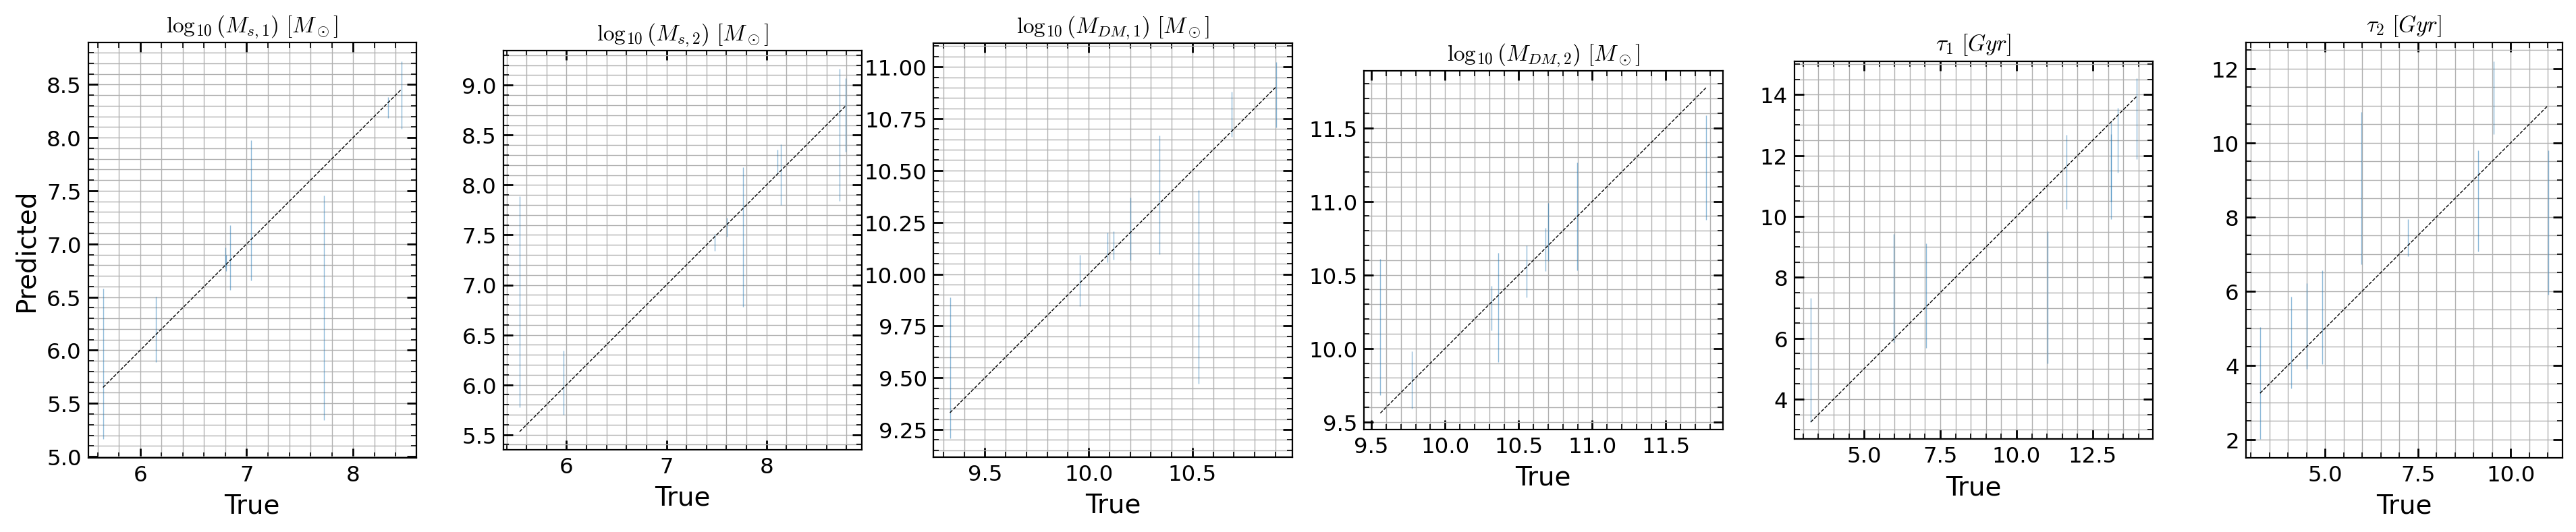

In [6]:
metric = PosteriorCoverage(num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load('./x_test.npy')), theta=torch.from_numpy(np.load('./theta_test.npy'))
)

fig[3].savefig('coverage_2subhalos.png')

In [7]:
from sbibm.metrics.c2st import c2st
from sbibm.metrics.mmd import mmd
theta_test = torch.from_numpy(np.load('./theta_test.npy')).to('cuda')
x_test = torch.from_numpy(np.load('./x_test.npy')).to('cuda')
posterior_mean = torch.zeros_like(theta_test)
posterior_std = torch.zeros_like(theta_test)
for i, x_0 in enumerate(x_test):
    posterior_mean[i] = samples['NPE'].sample((10_000,), x=x_0).mean(axis=0)
    posterior_std[i] = samples['NPE'].sample((10_000,), x=x_0).std(axis=0)

c2st_score = c2st(theta_test, posterior_samples)
mmd_score = mmd(theta_test, posterior_samples)

mre = ((theta_test - posterior_mean).abs() / theta_test.abs()).mean(axis=0)
r2 = 1 - ((theta_test - posterior_mean)**2).sum(axis=0) / ((theta_test - theta_test.mean(axis=0))**2).sum(axis=0)
mse = ((theta_test - posterior_mean)**2).mean(axis=0)
chi2 = ((theta_test - posterior_mean)**2 / posterior_std**2).mean(axis=0)

print('c2st score:', c2st_score)
print('mmd^2 score:', mmd_score**2)
print('MRE:', mre)
print('R2:', r2)
print('MSE:', mse)
print('chi2:', chi2)

Drawing 1234 posterior samples:   0%|          | 0/1234 [00:00<?, ?it/s]

Drawing 3117 posterior samples:   0%|          | 0/3117 [00:00<?, ?it/s]

Drawing 3316 posterior samples:   0%|          | 0/3316 [00:00<?, ?it/s]

Drawing 2333 posterior samples:   0%|          | 0/2333 [00:00<?, ?it/s]

Drawing 1259 posterior samples:   0%|          | 0/1259 [00:00<?, ?it/s]

Drawing 3126 posterior samples:   0%|          | 0/3126 [00:00<?, ?it/s]

Drawing 3353 posterior samples:   0%|          | 0/3353 [00:00<?, ?it/s]

Drawing 2262 posterior samples:   0%|          | 0/2262 [00:00<?, ?it/s]

Drawing 1301 posterior samples:   0%|          | 0/1301 [00:00<?, ?it/s]

Drawing 3219 posterior samples:   0%|          | 0/3219 [00:00<?, ?it/s]

Drawing 3253 posterior samples:   0%|          | 0/3253 [00:00<?, ?it/s]

Drawing 2227 posterior samples:   0%|          | 0/2227 [00:00<?, ?it/s]

Drawing 1284 posterior samples:   0%|          | 0/1284 [00:00<?, ?it/s]

Drawing 3180 posterior samples:   0%|          | 0/3180 [00:00<?, ?it/s]

Drawing 3293 posterior samples:   0%|          | 0/3293 [00:00<?, ?it/s]

Drawing 2243 posterior samples:   0%|          | 0/2243 [00:00<?, ?it/s]

Drawing 1293 posterior samples:   0%|          | 0/1293 [00:00<?, ?it/s]

Drawing 3161 posterior samples:   0%|          | 0/3161 [00:00<?, ?it/s]

Drawing 3277 posterior samples:   0%|          | 0/3277 [00:00<?, ?it/s]

Drawing 2269 posterior samples:   0%|          | 0/2269 [00:00<?, ?it/s]

Drawing 1276 posterior samples:   0%|          | 0/1276 [00:00<?, ?it/s]

Drawing 3101 posterior samples:   0%|          | 0/3101 [00:00<?, ?it/s]

Drawing 3256 posterior samples:   0%|          | 0/3256 [00:00<?, ?it/s]

Drawing 2367 posterior samples:   0%|          | 0/2367 [00:00<?, ?it/s]

Drawing 1272 posterior samples:   0%|          | 0/1272 [00:00<?, ?it/s]

Drawing 3140 posterior samples:   0%|          | 0/3140 [00:00<?, ?it/s]

Drawing 3334 posterior samples:   0%|          | 0/3334 [00:00<?, ?it/s]

Drawing 2254 posterior samples:   0%|          | 0/2254 [00:00<?, ?it/s]

Drawing 1275 posterior samples:   0%|          | 0/1275 [00:00<?, ?it/s]

Drawing 3169 posterior samples:   0%|          | 0/3169 [00:00<?, ?it/s]

Drawing 3341 posterior samples:   0%|          | 0/3341 [00:00<?, ?it/s]

Drawing 2215 posterior samples:   0%|          | 0/2215 [00:00<?, ?it/s]

Drawing 1282 posterior samples:   0%|          | 0/1282 [00:00<?, ?it/s]

Drawing 3194 posterior samples:   0%|          | 0/3194 [00:00<?, ?it/s]

Drawing 3282 posterior samples:   0%|          | 0/3282 [00:00<?, ?it/s]

Drawing 2242 posterior samples:   0%|          | 0/2242 [00:00<?, ?it/s]

Drawing 1250 posterior samples:   0%|          | 0/1250 [00:00<?, ?it/s]

Drawing 3197 posterior samples:   0%|          | 0/3197 [00:00<?, ?it/s]

Drawing 3301 posterior samples:   0%|          | 0/3301 [00:00<?, ?it/s]

Drawing 2252 posterior samples:   0%|          | 0/2252 [00:00<?, ?it/s]

Drawing 1325 posterior samples:   0%|          | 0/1325 [00:00<?, ?it/s]

Drawing 3068 posterior samples:   0%|          | 0/3068 [00:00<?, ?it/s]

Drawing 3422 posterior samples:   0%|          | 0/3422 [00:00<?, ?it/s]

Drawing 2185 posterior samples:   0%|          | 0/2185 [00:00<?, ?it/s]

Drawing 1255 posterior samples:   0%|          | 0/1255 [00:00<?, ?it/s]

Drawing 3245 posterior samples:   0%|          | 0/3245 [00:00<?, ?it/s]

Drawing 3259 posterior samples:   0%|          | 0/3259 [00:00<?, ?it/s]

Drawing 2241 posterior samples:   0%|          | 0/2241 [00:00<?, ?it/s]

Drawing 1274 posterior samples:   0%|          | 0/1274 [00:00<?, ?it/s]

Drawing 3096 posterior samples:   0%|          | 0/3096 [00:00<?, ?it/s]

Drawing 3341 posterior samples:   0%|          | 0/3341 [00:00<?, ?it/s]

Drawing 2289 posterior samples:   0%|          | 0/2289 [00:00<?, ?it/s]

Drawing 1243 posterior samples:   0%|          | 0/1243 [00:00<?, ?it/s]

Drawing 3151 posterior samples:   0%|          | 0/3151 [00:00<?, ?it/s]

Drawing 3335 posterior samples:   0%|          | 0/3335 [00:00<?, ?it/s]

Drawing 2271 posterior samples:   0%|          | 0/2271 [00:00<?, ?it/s]

Drawing 1287 posterior samples:   0%|          | 0/1287 [00:00<?, ?it/s]

Drawing 3251 posterior samples:   0%|          | 0/3251 [00:00<?, ?it/s]

Drawing 3232 posterior samples:   0%|          | 0/3232 [00:00<?, ?it/s]

Drawing 2230 posterior samples:   0%|          | 0/2230 [00:00<?, ?it/s]

Drawing 1250 posterior samples:   0%|          | 0/1250 [00:00<?, ?it/s]

Drawing 3149 posterior samples:   0%|          | 0/3149 [00:00<?, ?it/s]

Drawing 3333 posterior samples:   0%|          | 0/3333 [00:00<?, ?it/s]

Drawing 2268 posterior samples:   0%|          | 0/2268 [00:00<?, ?it/s]

Drawing 1277 posterior samples:   0%|          | 0/1277 [00:00<?, ?it/s]

Drawing 3169 posterior samples:   0%|          | 0/3169 [00:00<?, ?it/s]

Drawing 3288 posterior samples:   0%|          | 0/3288 [00:00<?, ?it/s]

Drawing 2266 posterior samples:   0%|          | 0/2266 [00:00<?, ?it/s]

Drawing 1321 posterior samples:   0%|          | 0/1321 [00:00<?, ?it/s]

Drawing 3101 posterior samples:   0%|          | 0/3101 [00:00<?, ?it/s]

Drawing 3308 posterior samples:   0%|          | 0/3308 [00:00<?, ?it/s]

Drawing 2270 posterior samples:   0%|          | 0/2270 [00:00<?, ?it/s]

c2st score: tensor([0.9982])
mmd^2 score: tensor(0.0016, device='cuda:0', dtype=torch.float64)
MRE: tensor([0.0320, 0.0387, 0.0114, 0.0147, 0.1828, 0.1606], device='cuda:0',
       dtype=torch.float64)
R2: tensor([0.7312, 0.8207, 0.7603, 0.8046, 0.7777, 0.6394], device='cuda:0',
       dtype=torch.float64)
MSE: tensor([0.2087, 0.2038, 0.0447, 0.0721, 2.9512, 2.4010], device='cuda:0',
       dtype=torch.float64)
chi2: tensor([0.3038, 0.3927, 0.3270, 0.4548, 0.9170, 0.9083], device='cuda:0',
       dtype=torch.float64)
